In [34]:
import numpy as np
import dicom
import os
import fnmatch
import re
import cv2


%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
f = dicom.read_file('/home/thomas/Kaggle/heart/data_kaggle/train/1/study/2ch_21/IM-4572-0002.dcm')

In [8]:
img = f.pixel_array.astype(np.int)

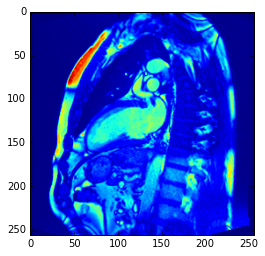

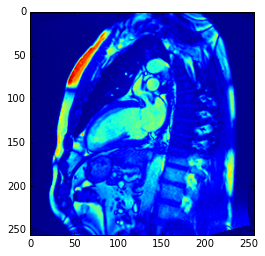

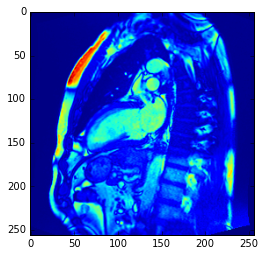

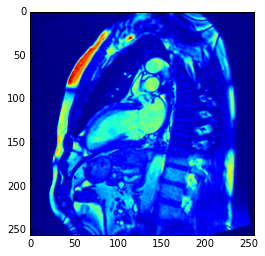

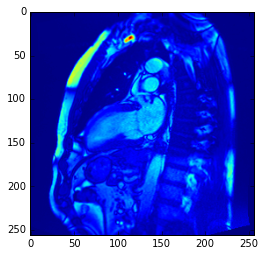

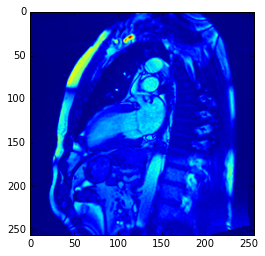

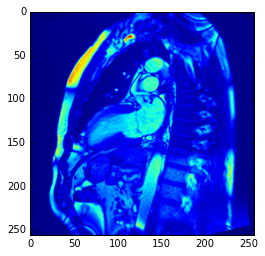

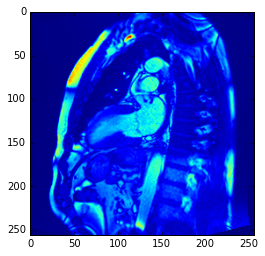

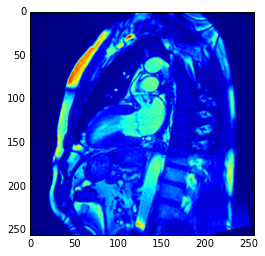

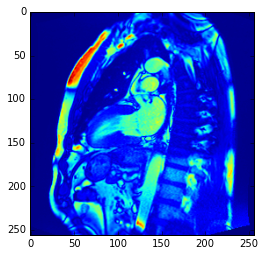

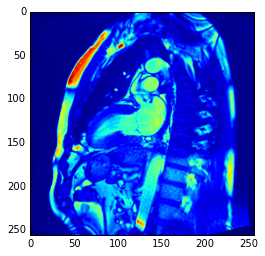

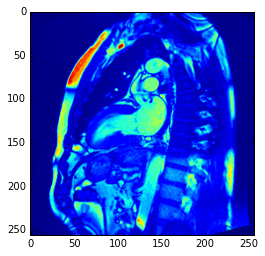

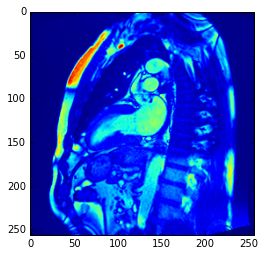

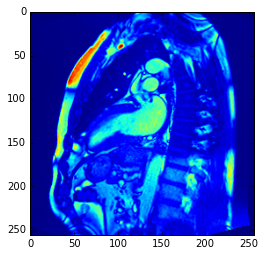

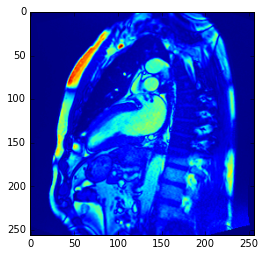

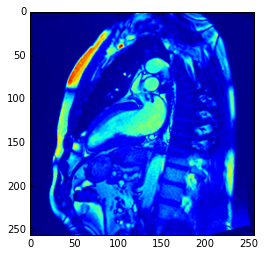

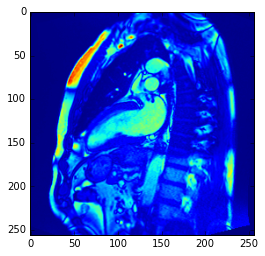

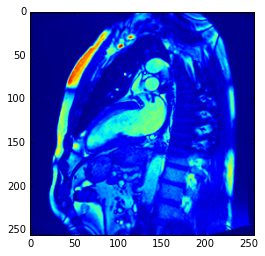

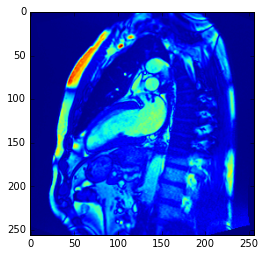

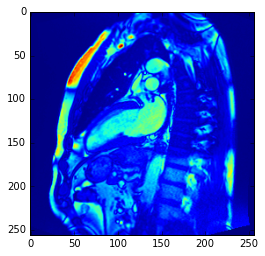

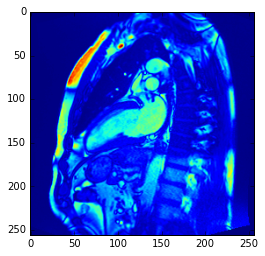

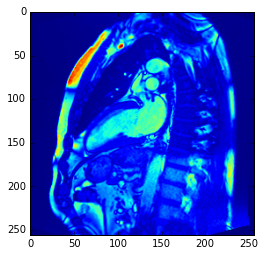

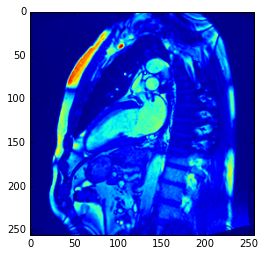

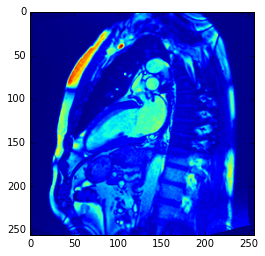

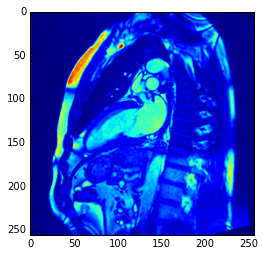

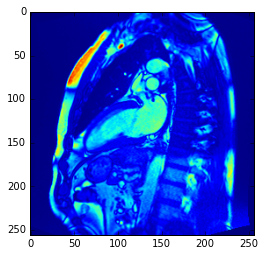

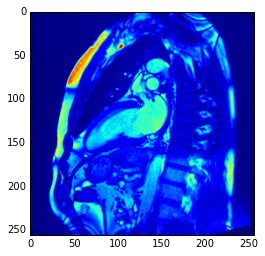

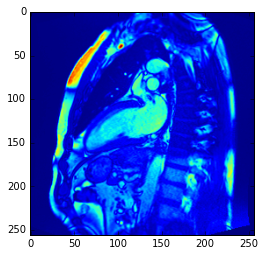

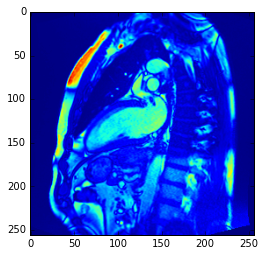

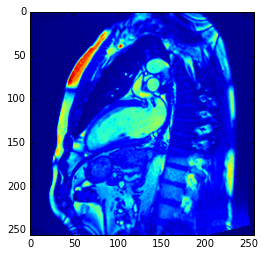

In [22]:
for i in range(30):
    plt.figure()
    f = dicom.read_file('/home/thomas/Kaggle/heart/data_kaggle/train/1/study/2ch_21/IM-4572-00%.2d.dcm'%(i+1))
    img = f.pixel_array.astype(np.int)
    plt.imshow(img)

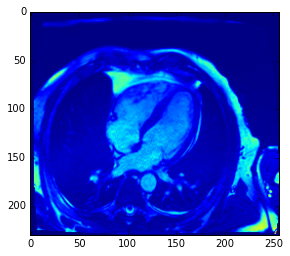

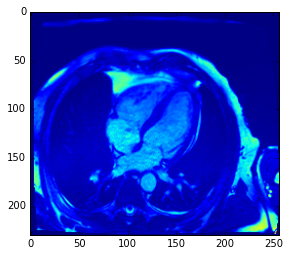

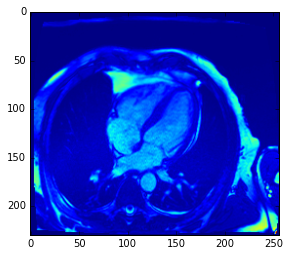

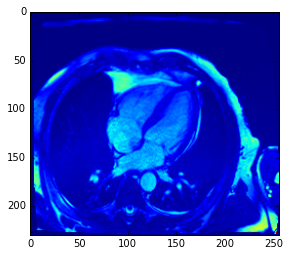

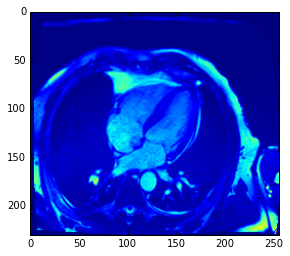

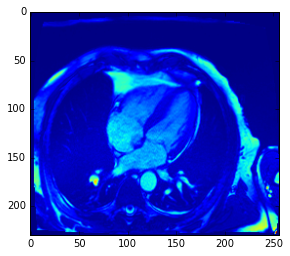

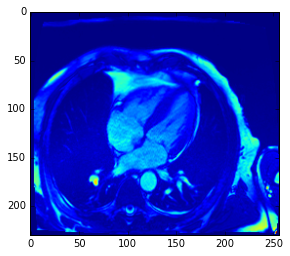

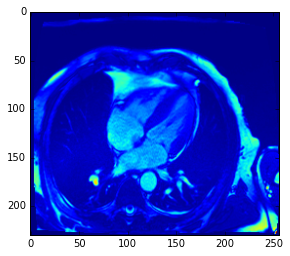

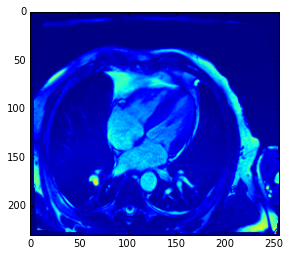

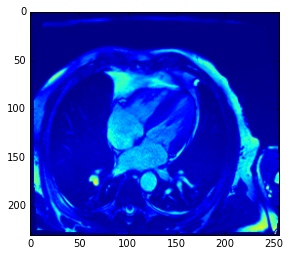

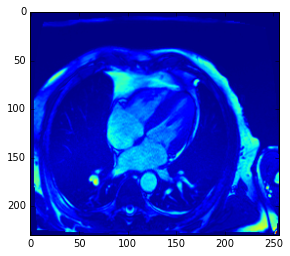

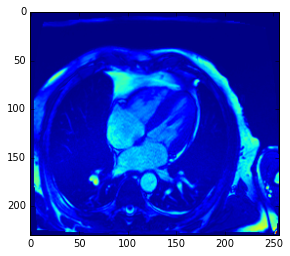

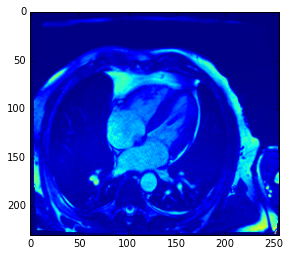

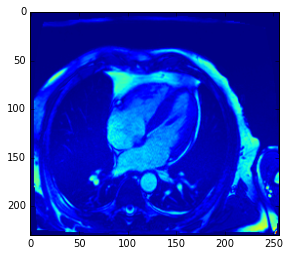

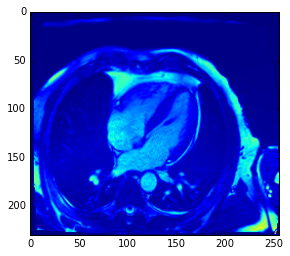

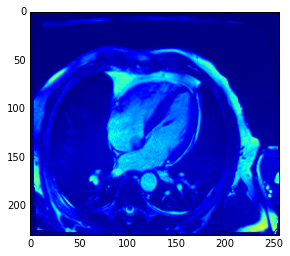

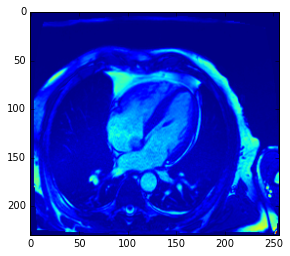

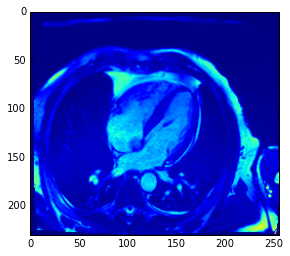

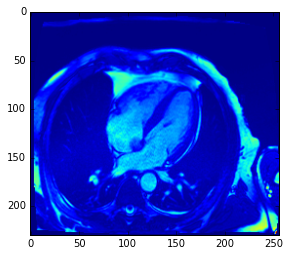

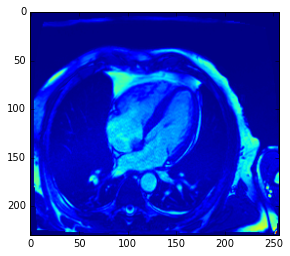

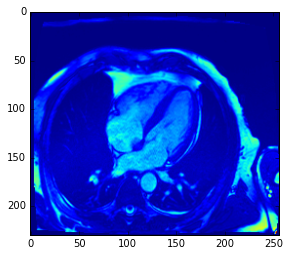

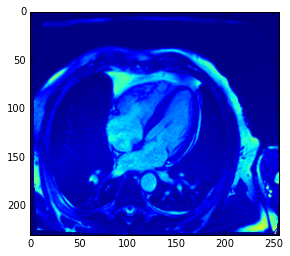

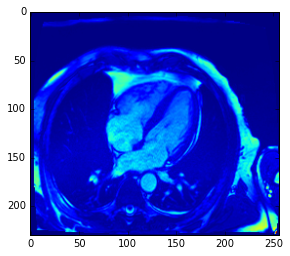

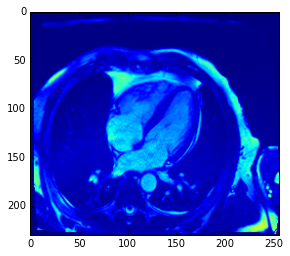

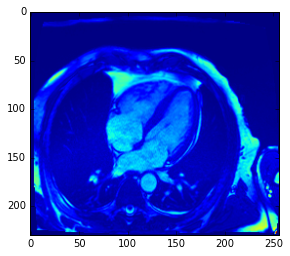

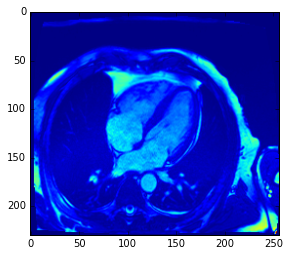

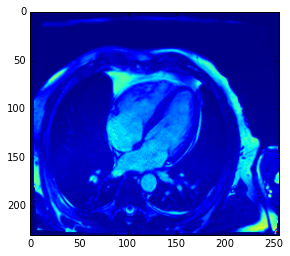

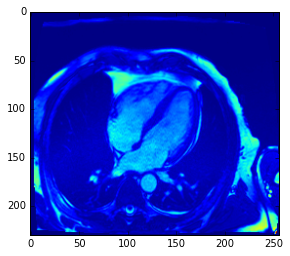

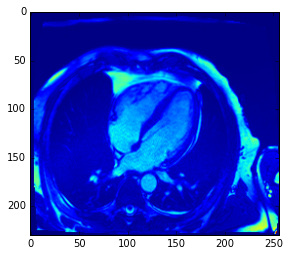

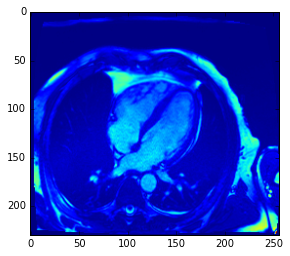

In [21]:
for i in range(30):
    plt.figure()
    f = dicom.read_file('/home/thomas/Kaggle/heart/data_kaggle/train/1/study/4ch_20/IM-4571-00%.2d.dcm'%(i+1))
    img = f.pixel_array.astype(np.int)
    plt.imshow(img)

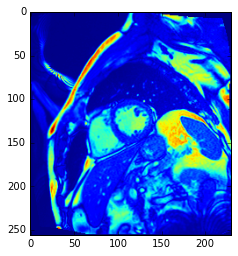

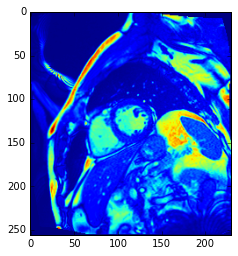

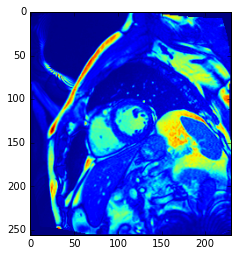

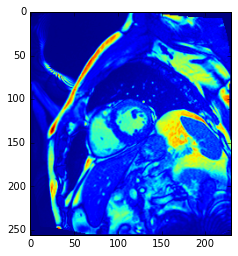

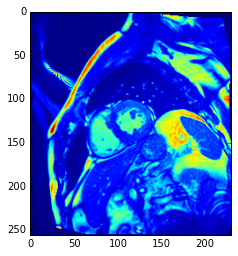

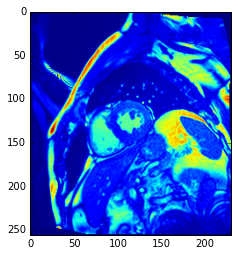

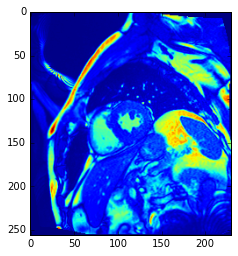

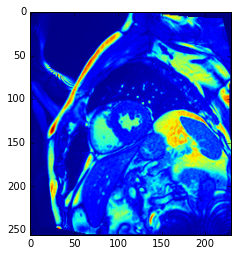

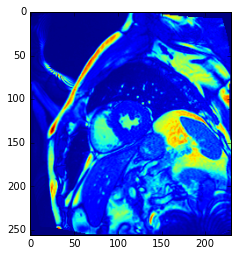

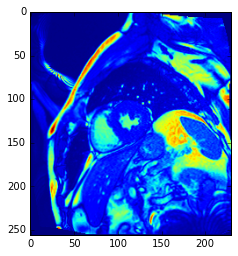

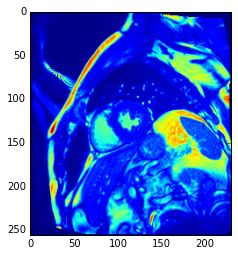

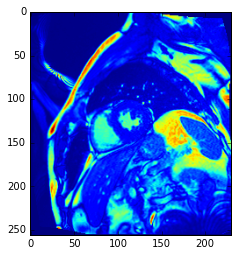

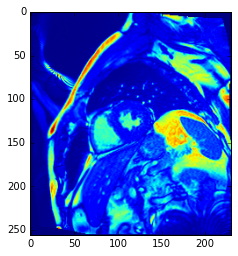

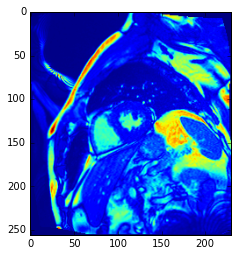

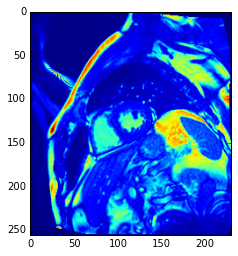

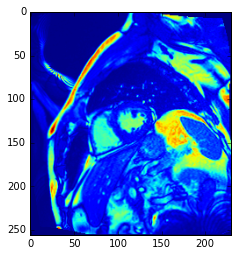

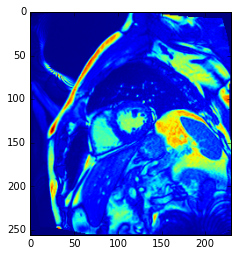

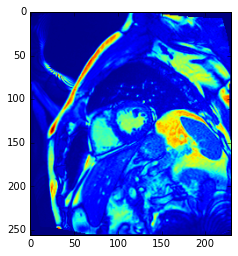

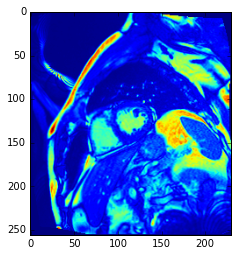

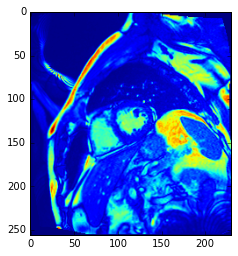

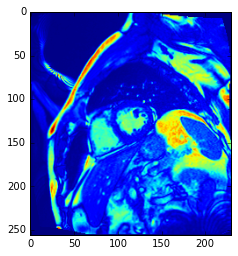

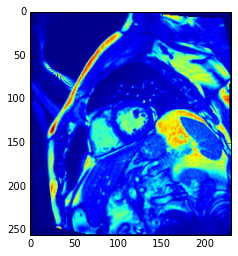

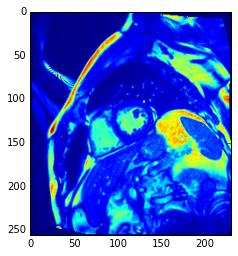

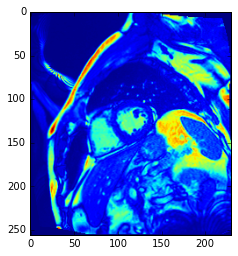

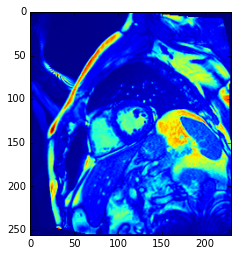

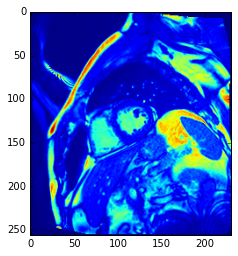

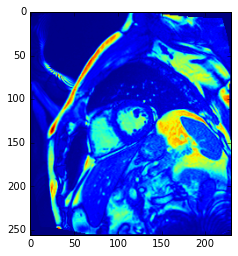

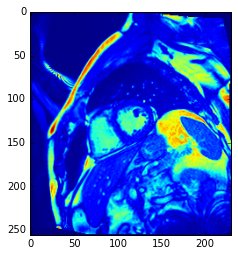

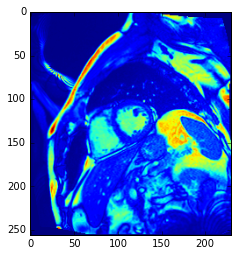

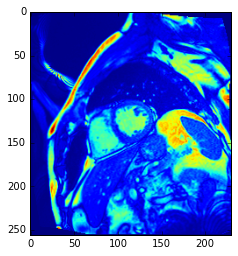

In [20]:
for i in range(30):
    plt.figure()
    f = dicom.read_file('/home/thomas/Kaggle/heart/data_kaggle/train/1/study/sax_10/IM-4562-00%.2d.dcm'%(i+1))
    img = f.pixel_array.astype(np.int)
    plt.imshow(img)

In [26]:
SAX_SERIES = {
    # challenge training
    "SC-HF-I-1": "0004",
    "SC-HF-I-2": "0106",
    "SC-HF-I-4": "0116",
    "SC-HF-I-40": "0134",
    "SC-HF-NI-3": "0379",
    "SC-HF-NI-4": "0501",
    "SC-HF-NI-34": "0446",
    "SC-HF-NI-36": "0474",
    "SC-HYP-1": "0550",
    "SC-HYP-3": "0650",
    "SC-HYP-38": "0734",
    "SC-HYP-40": "0755",
    "SC-N-2": "0898",
    "SC-N-3": "0915",
    "SC-N-40": "0944",
}

SUNNYBROOK_ROOT_PATH = "/home/thomas/Kaggle/heart/data_sunnybrook/"

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart3",
                            "TrainingDataContours")
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "challenge_training")

def shrink_case(case):
    toks = case.split("-")
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        match = re.search(r"/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-icontour-manual.txt", ctr_path)
        self.case = shrink_case(match.group(1))
        self.img_no = int(match.group(2))
    
    def __str__(self):
        return "<Contour for case %s, image %d>" % (self.case, self.img_no)
    
    __repr__ = __str__

def load_contour(contour, img_path):
    filename = "IM-%s-%04d.dcm" % (SAX_SERIES[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    f = dicom.read_file(full_path)
    img = f.pixel_array.astype(np.int)
    ctrs = np.loadtxt(contour.ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
    return img, label
    
def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-0001-*-icontour-manual.txt')]
    print("Shuffle data")
    np.random.shuffle(contours)
    print("Number of examples: {:d}".format(len(contours)))
    extracted = map(Contour, contours)
    return extracted

def export_all_contours(contours, img_path, lmdb_img_name, lmdb_label_name):
    for lmdb_name in [lmdb_img_name, lmdb_label_name]:
        db_path = os.path.abspath(lmdb_name)
        if os.path.exists(db_path):
            shutil.rmtree(db_path)
    counter_img = 0
    counter_label = 0
    batchsz = 100
    print("Processing {:d} images and labels...".format(len(contours)))
    for i in xrange(int(np.ceil(len(contours) / float(batchsz)))):
        batch = contours[(batchsz*i):(batchsz*(i+1))]
        if len(batch) == 0:
            break
        imgs, labels = [], []
        for idx,ctr in enumerate(batch):
            try:
                img, label = load_contour(ctr, img_path)
                imgs.append(img)
                labels.append(label)
                if idx % 20 == 0:
                    print ctr
                    plt.imshow(img)
                    plt.show()
                    plt.imshow(label)
                    plt.show()
            except IOError:
                continue
        db_imgs = lmdb.open(lmdb_img_name, map_size=1e12)
        with db_imgs.begin(write=True) as txn_img:
            for img in imgs:
                datum = caffe.io.array_to_datum(np.expand_dims(img, axis=0))
                txn_img.put("{:0>10d}".format(counter_img), datum.SerializeToString())
                counter_img += 1
        print("Processed {:d} images".format(counter_img))
        db_labels = lmdb.open(lmdb_label_name, map_size=1e12)
        with db_labels.begin(write=True) as txn_label:
            for lbl in labels:
                datum = caffe.io.array_to_datum(np.expand_dims(lbl, axis=0))
                txn_label.put("{:0>10d}".format(counter_label), datum.SerializeToString())
                counter_label += 1
        print("Processed {:d} labels".format(counter_label))
    db_imgs.close()
    db_labels.close()

In [31]:
ctrs = get_all_contours(TRAIN_CONTOUR_PATH)

Shuffle data
Number of examples: 260


In [32]:
ctrs[0]

<Contour for case SC-HF-NI-34, image 139>

In [35]:
ctr = load_contour(ctrs[0], TRAIN_IMG_PATH)

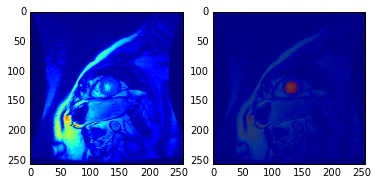

In [50]:
plt.subplot(1,2,1)
plt.imshow(ctr[0])
plt.subplot(1,2,2)
plt.imshow(ctr[0])
plt.imshow(ctr[1], alpha=0.8)

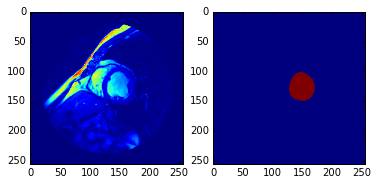

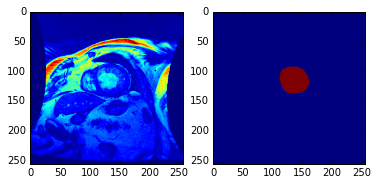

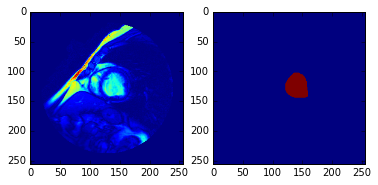

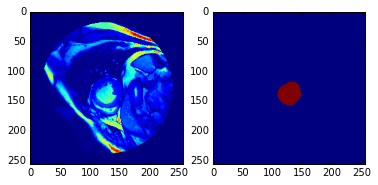

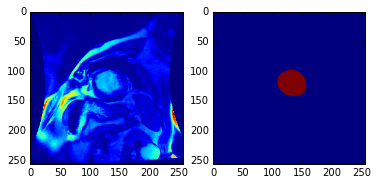

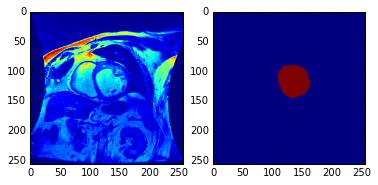

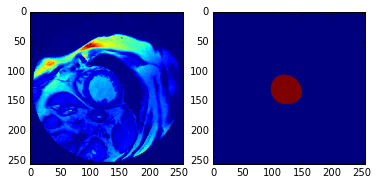

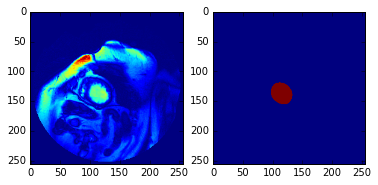

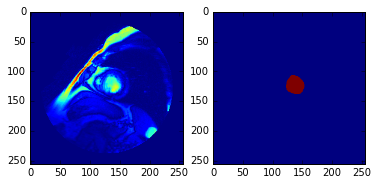

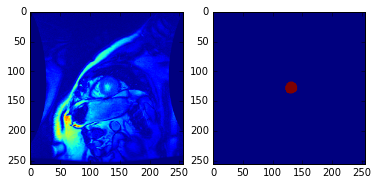

In [46]:
for i in range(10):
    plt.figure()
    
    ctr = load_contour(ctrs[i], TRAIN_IMG_PATH)
    plt.subplot(1,2,1)
    plt.imshow(ctr[0])
    plt.subplot(1,2,2)
    plt.imshow(ctr[1])